## 0. Execution

In the section for performing Attack there is a variable PERFORM_ATTACK = FALSE for plot the result, if PERFORM_ATTACK = TRUE exec the attack and save result


## 1. Loading prereqs

In [1]:
try:
    from google.colab import drive
    IN_COLAB = True
    print("Running on Google Colab. ")
except:
    IN_COLAB = False
    print("Not running on Google Colab. ")

Not running on Google Colab. 


In [2]:
if IN_COLAB:
    !pip install facenet-pytorch  # fornisce modelli pre-addestrati PyTorch per compiti di riconoscimento facciale
    !pip install Pillow # aggiunge il supporto per l'apertura, la manipolazione e il salvataggio di molti diversi formati di file immagine.



#### Connect to Drive

In [3]:
# Verifica se sei su colab o no
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir("/content/drive/Shareddrives/AI4CYBSEC")

In [4]:
import os
os.getcwd()

'g:\\Drive condivisi\\AI4CYBSEC'

## 2 Load Models

### 2.1 Load NN1

#### Load pre-trained model





In [5]:
# utilizzo la libreria facenet_pytorch per caricare il modello InceptionResnetV1 preaddestrato sul dataset VGGFace2 e abilitare la classificazione.
from facenet_pytorch import InceptionResnetV1, MTCNN
import torch

# Seleziono il device su cui eseguire il codice come cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet = InceptionResnetV1(pretrained='vggface2',device=device).eval()
resnet.classify = True

print('Running on device: {}'.format(device))
resnet = resnet.to(device)



Running on device: cuda:0


#### Loading labels of model

In [6]:
import numpy as np
import tensorflow as tf

# Il modello è addestrato sulle seguenti Labels:
# Carico le labels del dataset VGGFACE
fpath = tf.keras.utils.get_file('rcmalli_vggface_labels_v2.npy',
                             "https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_labels_v2.npy",
                             cache_subdir="./")
LABELS = np.load(fpath) # List of name
# Clean list of name
#name_LABELS={}
for i in range(len(LABELS)):
  LABELS[i] = LABELS[i].strip().replace(' ', '').replace('"', '')
  #name_LABELS[LABELS[i]]=i



### 2.2 Load NN2

#### Load repository for NN2

In [7]:

import os
if not os.path.exists('VGGFace2_pytorch'):
    !git clone https://github.com/cydonia999/VGGFace2-pytorch.git
    !mv VGGFace2-pytorch VGGFace2_pytorch


#### Import from repository and import for operation

In [8]:
import torch
from VGGFace2_pytorch.models import senet as SENet
from VGGFace2_pytorch.models.resnet import resnet50 as ResNet
from VGGFace2_pytorch import utils
from VGGFace2_pytorch.trainer import Validator
from torch.utils.data import DataLoader
from VGGFace2_pytorch.datasets.vgg_face2 import VGG_Faces2
import os
from torch.nn.modules.loss import CrossEntropyLoss

#### Load Model from pickel file

In [9]:
model = SENet.senet50(num_classes = 8631, include_top = True)
if IN_COLAB:
    weights_pickel = "/content/drive/Shareddrives/AI4CYBSEC/in_progress/senet50_ft_weight.pkl"
else:
    weights_pickel = ".\in_progress\senet50_ft_weight.pkl"
utils.load_state_dict(model, weights_pickel)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model.to(device)
import torchsummary
torchsummary.summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13             [-1, 16, 1, 1]           4,112
             ReLU-14             [-1, 1

## 3. Load Test Set

#### Load the label of Test Set

In [10]:
# set the path for the dataset
if IN_COLAB:
  path_dataset = "/content/drive/Shareddrives/AI4CYBSEC/face_dataset"
else:
    path_dataset = "./face_dataset"
identity_meta_NN1_name = "meta_identity_NN1.csv"
# for NN1
import pandas as pd
import os

path_identity_csv =os.path.join(path_dataset,identity_meta_NN1_name)
identity_meta_NN1 = pd.read_csv(path_identity_csv)

## 4. Mapping different label encoding

### 4.1 Mapping label for NN1

In [11]:
# I want a dictonary related to the label of the Test Set that map the name of celebrities with label associated
name_to_id = {}
id_to_name = {}
for index, row in identity_meta_NN1.iterrows():
    # Ora puoi accedere ai valori di ogni riga come segue:
    class_id = row['Class_ID']
    name = row['Name']
    name_to_id[name]=class_id
    id_to_name[class_id] = name

### 4.2 Mapping label for NN2

##### Function to create image list file for NN2 evaluation

In [12]:
import os
def create_image_list_file(root_dir, output_file, ext = '.jpg'):

    image_paths = []

    for class_id in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_id)

        if os.path.isdir(class_dir):

            for filename in os.listdir(class_dir):

                if filename.endswith(ext):
                    image_path = f"{os.path.basename(root_dir)}/{class_id}/{filename}"
                    image_paths.append(image_path)

    with open(output_file, 'w') as f:
        for image_path in image_paths:
            f.write(image_path + '\n')

    print(f"File di output creato con successo: {output_file}")

##### Mapping pipline NN2

In [13]:
test_set_NN2 = "test_set_MTCNN_NN2"
if IN_COLAB:
    output_file = '/content/drive/Shareddrives/AI4CYBSEC/image_list_file_NN2.txt'
    meta_file = "/content/drive/Shareddrives/AI4CYBSEC/face_dataset/identity_meta.csv"
else:
    output_file = 'image_list_file_NN2.txt'
    meta_file = ".\\face_dataset\identity_meta.csv"
root_dir = os.path.join(path_dataset,test_set_NN2)
create_image_list_file(root_dir, output_file)
id_label_dict = utils.get_id_label_map(meta_file)

File di output creato con successo: image_list_file_NN2.txt


g:\Drive condivisi\AI4CYBSEC\VGGFace2_pytorch\utils.py:37: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(identity_list, sep=',\s+', quoting=csv.QUOTE_ALL, encoding="utf-8")


## 5. Evaluate model


### 5.1 Evaluate model NN1

#### Dataset Class for NN1

In [14]:
from PIL import Image
import os
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class VGGFace2Dataset(Dataset):
    def __init__(self, root_dir, image_size=(160, 160), transform=None):
        self.root_dir = root_dir
        self.image_size = image_size
        self.transform = transform

        # List of files in the dataset
        self.file_list = []
        for root, dirs, files in os.walk(self.root_dir):
            for file in files:
                self.file_list.append(os.path.join(root, file))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).resize(self.image_size)

        # Extract the label from the file path
        label = os.path.split(os.path.dirname(img_path))[-1]

        if self.transform:
            img = self.transform(img)

        return img, label

#### Utility Function for NN1 with mapping labels

In [15]:

from PIL import Image
from torchvision import transforms
import torch
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

def load_image(file_path, size=(160, 160))    :
    """ carica un'immagine da un percorso e la apre come un'immagine utilizzando Image.open dal modulo Pillow.
    Successivamente, ridimensiona l'immagine a dimensioni 160x160 pixel e la converte in un tensore utilizzando
    transforms.ToTensor() dal modulo torchvision.transforms.
    Infine, restituisce sia il tensore dell'immagine che l'immagine aperta.
    """
    rsz = Image.open(file_path).resize(size)
    tns = transforms.ToTensor()(rsz)
    return tns, rsz
def make_inference(model, image_tensors, name_to_id, device):
    """
    Takes input image tensor and returns the label associated with the network's prediction.

    """
    model.to(device)
    model.eval()
    # Move image tensors to the specified device
    image_tensors = image_tensors.to(device)

    probs = model(image_tensors)
    #print("probs", probs)

    # Get the number of elements along the first dimension
    num_elements = probs.size(0)

    # Initialize two lists to store the argmax
    argmax_list_1 = []
    argmax_list_2 = []

    # Compute argmax for each element along the first dimension
    for i in range(num_elements):
        #target_class = np.array(probs[i].detach().cpu().numpy()).argmax()  # Move to CPU for numpy operations
        target_class = torch.argmax(probs[i]).item()
        argmax_list_1.append(name_to_id[LABELS[target_class]])
        argmax_list_2.append(target_class)

    return argmax_list_1, argmax_list_2

def validate(dataset, model, name_to_id, device):
    """
    Validates a model on a dataset and returns the accuracy.

    Args:
        dataset: Dataloader to validate the model on.
        model: Model to validate.
        device: Device to perform inference on.

    Returns:
        accuracy: Accuracy of the model on the dataset.
    """
    model.to(device)
    model.eval()
    correct_predictions = 0
    total_samples = len(dataset) * dataset.batch_size

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in tqdm(dataset, desc="Validating model"):
            #images = mtcnn(images)
            predicted_classes, _ = make_inference(model, images, name_to_id, device)
            correct_predictions += sum(pred == label for pred, label in zip(predicted_classes, labels))

    # Compute accuracy
    accuracy = correct_predictions / total_samples
    return accuracy


def plot_image(original_image, original_label):
  """
  prende in ingresso le PIL.Image del campione originale e del corrispondete adversarial sample e li plotta
  """
  plt.figure()
  plt.matshow(original_image)
  plt.title("Model Prediction: {}".format(original_label))
  plt.show()

#### Validation on Clean Data NN1

In [16]:
# Create transform for image resizing and normalization

data_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor()
])

if IN_COLAB:
  test_set_path = "/content/drive/Shareddrives/AI4CYBSEC/face_dataset/test_set_MTCNN"
else:
  test_set_path = "./face_dataset/test_set_MTCNN"
# Define dataset
dataset = VGGFace2Dataset(root_dir=test_set_path, transform=data_transform)

# Check the length of the dataset
print("Dataset length:", len(dataset))

# Create DataLoader
batch_size = 1
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
acc = validate(dataloader, resnet, name_to_id, device)
print("\n Accuracy without defense "+str(acc))

Dataset length: 998


Validating model: 100%|██████████| 998/998 [26:17<00:00,  1.58s/it]


 Accuracy without defense 0.8316633266533067


### 5.2 Evaluate model NN2

#### Utility function for NN2

In [16]:
def preprocessing_on_tensor(img_tensor, mean_bgr=np.array([91.4953, 103.8827, 131.0912])):
    """
    Perform preprocessing on the input image tensor for the model.

    :param img_tensor: immagine with shape (C, H, W) and values in [0, 1]
    :return: immagine normalizzata using mean_bgr with shape (1, C, H, W)

    """
    img = img_tensor.squeeze(0)
    img = img.numpy()
    img = (img * 255).astype(np.uint8)
    mean_bgr = np.array([91.4953,103.8827, 131.0912])
    # img è C x H x W --> H x W x C
    img = np.transpose(img, (1, 2, 0))
    img = img[:, :, ::-1]  # RGB -> BGR
    img = img.astype(np.float32)
    img -= mean_bgr
    img = img.transpose(2, 0, 1)
    img_tensor = torch.from_numpy(img).unsqueeze(0)
    return img_tensor


def make_inference_NN2(model, img_tensor, device, with_preprocessing=True):
    """
    Esegue l'inferenza su un'immagine.
    :param model: modello
    :param img_tensor: immagine trasformata
    :param device: dispositivo
    :return: predizione
    """
    if with_preprocessing:
        img_tensor = img_tensor.squeeze(0)
        img_tensor = preprocessing_on_tensor(img_tensor)
    model.eval()
    img_tensor = img_tensor.to(device)

    with torch.no_grad():
        output = model(img_tensor)
        pred = torch.argmax(output, dim=1).item()
    return pred

#### Validation on clean data NN2

In [18]:
val_dataset = VGG_Faces2(".//face_dataset", output_file, id_label_dict, split = 'valid')
val_loader = DataLoader(val_dataset, batch_size = 1)
validator = Validator(
            cmd = "test",
            cuda = True,
            model = model,
            criterion = CrossEntropyLoss(),
            val_loader = val_loader,
            log_file = "./log_file",
            print_freq = 1000,
        )

acc_NN2 = validator.validate()


Valid iteration=0 epoch=0:   0%|                        | 0/998 [00:00<?, ?it/s]

Test: [0/998/0]	epoch: 0	iter: 0	Time: 1.951 (1.951)	Loss: 0.0000 (0.0000)	Prec@1: 0.000 (0.000)	Prec@5: 0.000 (0.000)	


Accuracy: 88.38%


## 6. Perform Attack

### Install prereq

In [19]:
if IN_COLAB:
  !pip install adversarial-robustness-toolbox[all] # installa la libreria ART

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 98.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 96.0 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3


### Import Classifier

In [20]:
import art
from art.estimators.classification import PyTorchClassifier
from torch import nn, optim

input_shape = (3,160,160)
nb_classes = 8631
## Attack Gray Box
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss = nn.CrossEntropyLoss()
#loss = nn.TripletMarginLoss()
optimizer = optim.Adam(resnet.parameters())
classifier = PyTorchClassifier(model=resnet, loss=loss, input_shape=input_shape, nb_classes=nb_classes, optimizer=optimizer, clip_values=(0, 1))



### Utility for Attack

In [21]:
### Utility Functions to perform attacks
import numpy as np
import csv
from datetime import datetime
import json
import matplotlib
import matplotlib.pyplot as plt


def compute_perturbation(original_images, adversarial_samples):
    perturbations = []
    for original_image, adversarial_sample in zip(original_images, adversarial_samples):
        perturbation = np.mean(np.abs((np.array(original_image) - np.array(adversarial_sample))))
        perturbations.append(perturbation)
    return round(float(np.mean(perturbations)),3)


def sec_curve(strength_values, accuracies_values, constant_values, strength_name, target_class=None,
              attack=None, avg_perturbations=None, accuracy_on_target_class=None, network = "NN1"):
    fig, ax = plt.subplots()
    # Costruisci la stringa per i valori costanti
    constant_str = ', '.join([f'{key}: {value}' for key, value in constant_values.items()])
    line = ax.plot(np.array(strength_values), np.array(accuracies_values), 'b--', label=f'{network} - {constant_str}')


    # Aggiungi i valori costanti come parte della legenda
    if target_class:
        plt.title('Security Curve for Target Class {}'.format(target_class))
    else:
        plt.title('Security Curve')

    # Aggiungi l'attacco al titolo
    if attack:
        plt.title(f'{attack} - {plt.gca().get_title()}')

    plt.xlabel('Attack strength ({})'.format(strength_name))
    plt.ylabel('Accuracy Test')
    plt.grid()

    # Aggiungi il diagramma a barre di colore arancione per avg_perturbations
    if avg_perturbations:
        x = np.array(strength_values)
        ax2 = ax.twinx()
        bar = ax2.bar(x, avg_perturbations, color='orange', alpha=0.5, width=0.01, label='Avg Perturbations')
        ax2.set_ylabel('Avg Perturbations')



    if accuracy_on_target_class:
        # Aggiungi la curva di accuratezza per la classe target
        ax.plot(np.array(strength_values), np.array(accuracy_on_target_class), 'r--', label=f'{network} - mis_targ/miss')

    # Unisci le linee e le barre in una lista per la legenda
    handles, labels = ax.get_legend_handles_labels()
    if avg_perturbations:
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles += handles2
        labels += labels2

    # Mostra la legenda
    #plt.legend(handles, labels, loc='upper right', shadow=True, fontsize='small')
    #voglio che la legenda sia fuori dal grafico
    plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.2, 1), shadow=True, fontsize='small')
    plt.show()


def save_to_csv(attack_name, targeted, target_class, strength_name, strength_values, accuracy_values, constant_values, avg_perturbations, file_path, accuracy_on_target_class=None):
    # Intestazione del file CSV
    header = ["timestamp", "attacco", "targeted", "target_class", "strength_name", "strength_values", "accuracy_values", "constant_values", "avg_perturbations", "accuracy_on_target_class"]

    # Creazione della tupla con i valori da scrivere nel CSV
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    # Converti le liste di valori in stringhe JSON
    strength_values_json = json.dumps(strength_values)
    accuracy_values_json = json.dumps(accuracy_values)
    avg_perturbations_json = json.dumps(avg_perturbations)  # Converti avg_perturbations in una stringa JSON
    # Modifica: formatta strength_values come una lista di numeri invece di una stringa JSON
    accuracy_values_list = [float(val) for val in accuracy_values]
    # Modifica: converti accuracy_values in una lista di numeri
    row = (timestamp, attack_name, targeted, target_class, strength_name, strength_values_json, accuracy_values_list, json.dumps(constant_values), avg_perturbations_json)

    # Se accuracy_on_target_class è fornito e non è None, includilo nella tupla
    if accuracy_on_target_class is not None:
        accuracy_on_target_class_json = json.dumps(accuracy_on_target_class)  # Converti accuracy_on_target_class in una stringa JSON
        row += (accuracy_on_target_class_json,)
    else:
        row += (None,)  # Aggiungi None alla tupla

    # Scrittura nel file CSV in modalità append ('a')
    with open(file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        if file.tell() == 0:  # Se il file è vuoto, scrivi l'intestazione
            writer.writerow(header)
        writer.writerow(row)


def read_csv_and_plot(csv_file_path, network="NN1"):
    with open(csv_file_path, mode='r') as file:
        reader = csv.DictReader(file)

        for row in reader:
            timestamp = row["timestamp"]
            attack_name = row["attacco"]
            targeted = row["targeted"]
            target_class = row["target_class"]
            strength_name = row["strength_name"]
            strength_values = json.loads(row["strength_values"])
            accuracy_values = json.loads(row["accuracy_values"])
            constant_values = json.loads(row["constant_values"])
            avg_perturbations = json.loads(row["avg_perturbations"])
            accuracy_on_target_class = json.loads(row["accuracy_on_target_class"]) if row["accuracy_on_target_class"] else None

            # Controlla se accuracy_values è una stringa JSON e la elabora correttamente
            if isinstance(accuracy_values, str):
                accuracy_values = json.loads(accuracy_values)

            # Controlla se strength_values è una stringa JSON e la elabora correttamente
            if isinstance(strength_values, str):
                strength_values = json.loads(strength_values)

            # Controlla se strength_values è una stringa JSON e la elabora correttamente
            if isinstance(avg_perturbations, str):
                avg_perturbations = json.loads(avg_perturbations)

            # Chiama la funzione sec_curve per plottare la curva
            sec_curve(strength_values, accuracy_values, constant_values, strength_name, target_class, attack_name, avg_perturbations, accuracy_on_target_class, network)

### PGD attack -- NN1

In [22]:
PERFORM_ATTACK_NN1= False

#### Load list of images and labels

In [23]:
images_list = []
labels_list = []
images_adv_list = []
for image, label in dataloader:
    # Effettua le predizioni del modello
    # image numpy on device
    image_numpy = image.numpy()
    images_list.append(image_numpy)
    labels_list.append(label)

#### Set variable Perform Attack

In [24]:

if IN_COLAB:
  results_csv = "/content/drive/Shareddrives/AI4CYBSEC/results/PGD/attack_results_NN1.csv"
else:
  results_csv = "results\PGD\\attack_results_NN1.csv"
network = "NN1"

#### Perform attack Error Generic White Box

In [25]:
if PERFORM_ATTACK_NN1:
  from tqdm import tqdm
  from art.attacks.evasion import ProjectedGradientDescent
  import time

  attack_name = "PGD"
  targeted = False

  epsilon = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
  # Set the epsilon step size for the attack 1/10 of epsilon
  max_iters = [2, 5, 10]
  #max_iters = [ 5, 10, 20]
  num_random_init = 5 # for reproducibility
  target_class = None

  for max_iter in max_iters:
    accuracy = [acc]
    avg_perturbations = [0]
    for eps in epsilon:
      attack = ProjectedGradientDescent(estimator=classifier, eps=eps, eps_step=eps/10,
                                        max_iter=max_iter, num_random_init=num_random_init, targeted=targeted,
                                        verbose=False)
      correct = 0
      images_adv_list = []
      for img, label in tqdm(zip(images_list, labels_list), total=len(images_list),
                              desc="Attacking model with eps={} eps_step={} max_iter={} num_random_init={}".format(eps, eps/10, max_iter, num_random_init)):
        x_test_adv = attack.generate(img)
        images_adv_list.append(x_test_adv)
        x_test_adv = torch.tensor(x_test_adv)
        x_test_adv_pred,_ = make_inference(resnet, x_test_adv, name_to_id, device)
        if x_test_adv_pred[0] == label[0]:
          correct +=1
      accuracy.append(correct/len(images_list))
      avg_perturbations.append(compute_perturbation(images_list, images_adv_list))
    epsilon_ext= [0] + epsilon
    constant_values ={"max_iter":max_iter, "eps_step": "eps/10", "rnd_init":num_random_init}
    strength_name = "eps"

    sec_curve(epsilon_ext, accuracy, constant_values, strength_name, target_class, attack_name, avg_perturbations, None, network)
    # save results on csv
    save_to_csv(attack_name, targeted, target_class, strength_name, epsilon_ext, accuracy, constant_values, avg_perturbations, results_csv)


#### Perform attack Error Specific White Box

In [26]:
if PERFORM_ATTACK_NN1:
  from tqdm import tqdm
  from art.attacks.evasion import ProjectedGradientDescent
  import time

  attack_name = "PGD"
  targeted = True

  epsilon = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
  # Set the epsilon step size for the attack 1/10 of epsilon
  max_iters = [2, 5, 10]
  #max_iters = [ 20]
  num_random_init = 5 # for reproducibilityprint("\nCorrect Prediction: ", correct,"/",len(images_list), " Error equal target: ", error_equl_target,"/",len(images_list)-correct)

  target_class = 0 ## n000002
  """
  Target_label (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape
            (nb_samples,). Only provide this parameter if you'd like to use true labels when crafting
            adversarial samples. Otherwise, model predictions are used as labels to avoid the "label leaking" effect

  """
  #ndarray of shape (nb_samples, nb_classes) one-hot-encoded labels
  one_hot_bob_targeted_label = np.zeros((1, 8631))
  one_hot_bob_targeted_label[:, target_class] = 1

  for max_iter in max_iters:
    accuracy = [acc]
    avg_perturbations = [0]
    mis_equal_target_ratio = [0] # this is the case in wich I don't perform the attack (assumption)
    for eps in epsilon:
      attack = ProjectedGradientDescent(estimator=classifier, eps=eps, eps_step=eps/10,
                                        max_iter=max_iter, num_random_init=num_random_init, targeted=targeted,
                                        verbose=False)
      correct = 0
      error_equl_target=0
      images_adv_list = []
      for img, label in tqdm(zip(images_list, labels_list), total=len(images_list),
                              desc="Attacking model with eps={} eps_step={} max_iter={} num_random_init={}".format(eps, eps/10, max_iter, num_random_init)):
        x_test_adv = attack.generate(img, one_hot_bob_targeted_label)
        images_adv_list.append(x_test_adv)
        x_test_adv = torch.tensor(x_test_adv)
        x_test_adv_pred,x_test_adv_pred_model= make_inference(resnet, x_test_adv, name_to_id, device)
        if x_test_adv_pred[0] == label[0]:
          correct +=1
        elif x_test_adv_pred_model[0] == target_class:
          error_equl_target+=1
      print("Correct Prediction: ", correct,"/",len(images_list), " Error equal target: ", error_equl_target,"/",len(images_list)-correct)
      mis_equal_target_ratio.append(round(error_equl_target/(len(images_list)-correct),3))
      accuracy.append(correct/len(images_list))
      avg_perturbations.append(compute_perturbation(images_list, images_adv_list))
    epsilon_ext= [0] + epsilon
    constant_values ={"max_iter":max_iter,"eps_step": "eps/10", "rnd_init":num_random_init, }
    strength_name = "eps"
    sec_curve(epsilon_ext, accuracy, constant_values, strength_name, target_class, attack_name, avg_perturbations, mis_equal_target_ratio, network)
    # save results on csv
    save_to_csv(attack_name, targeted, target_class, strength_name, epsilon_ext, accuracy, constant_values, avg_perturbations, results_csv, mis_equal_target_ratio)


#### Plot from csv attack NN1 White-Bok

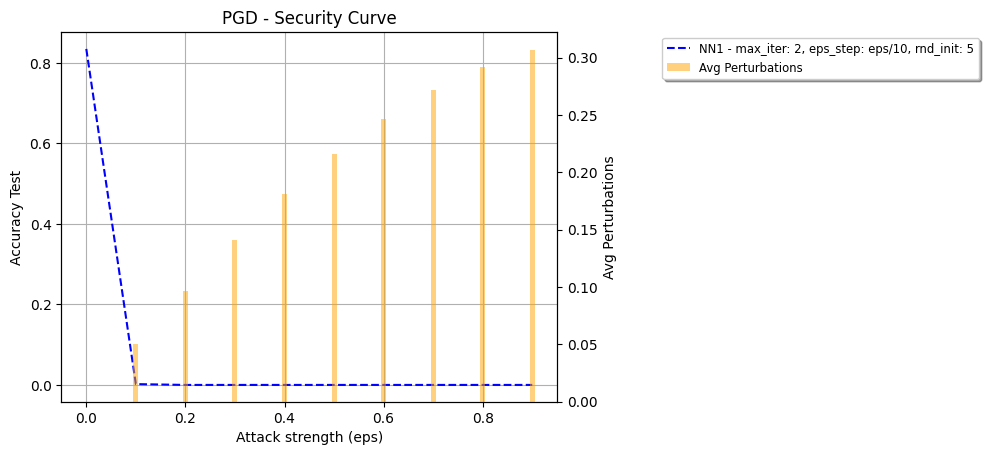

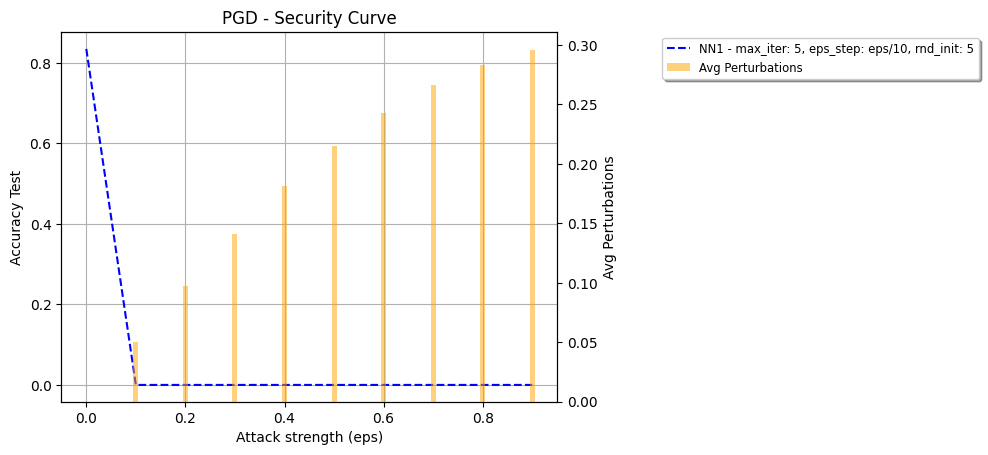

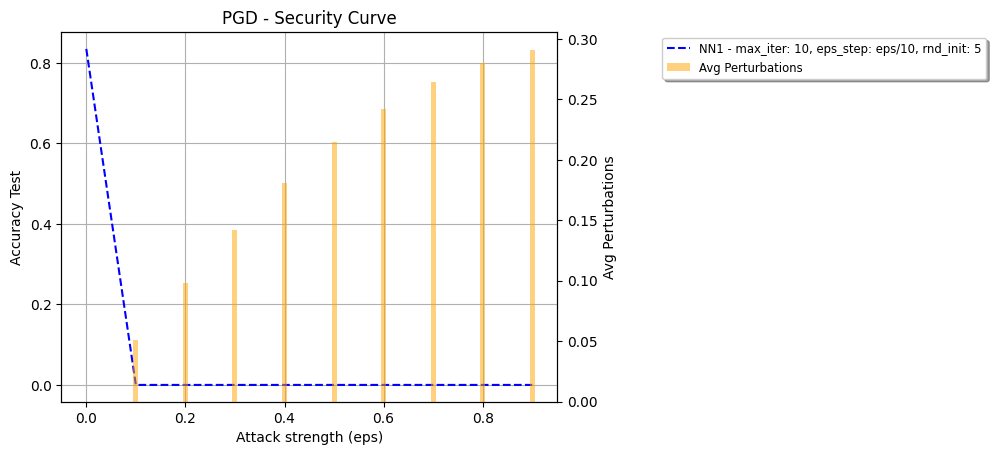

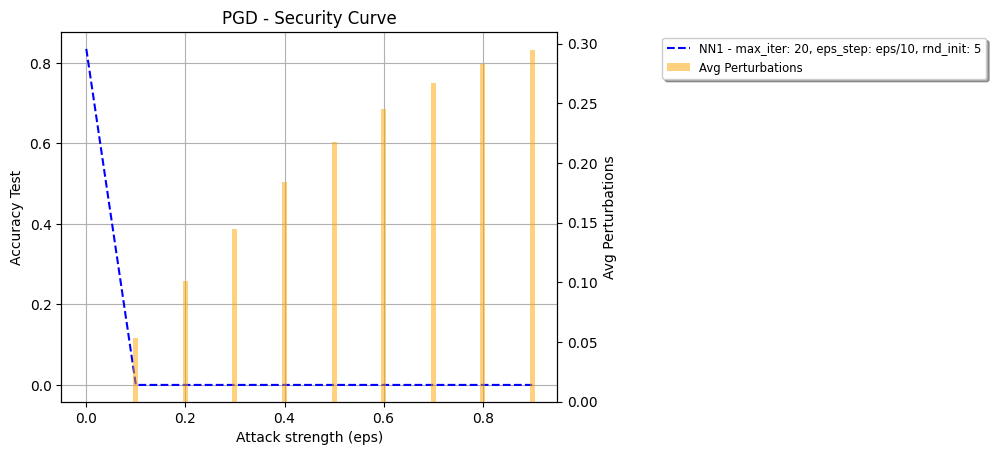

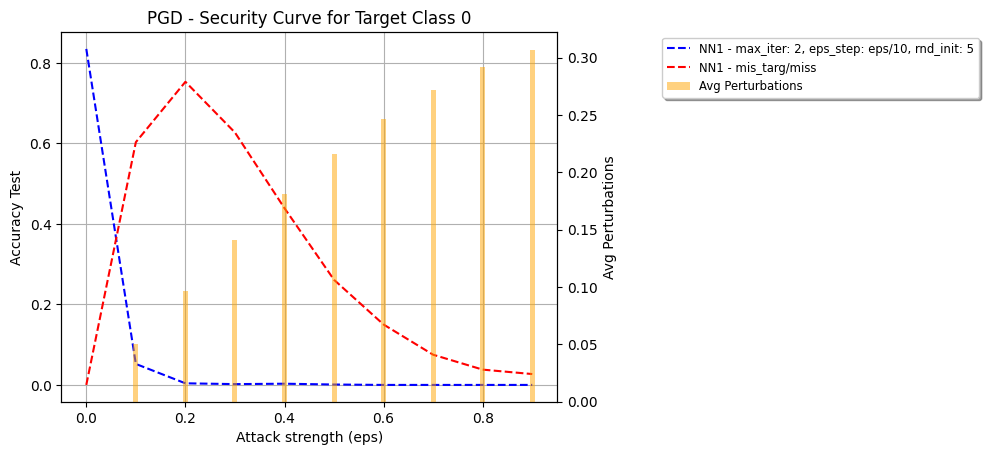

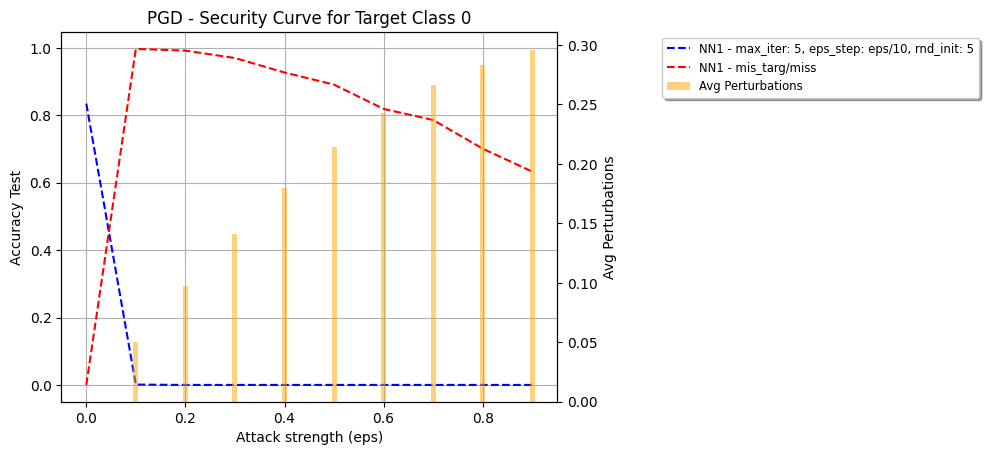

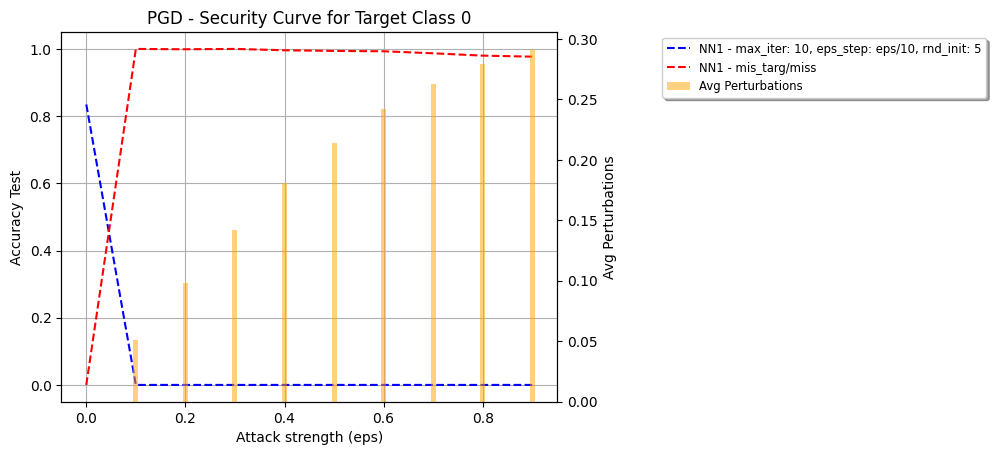

In [27]:
if IN_COLAB:
  results_csv = "/content/drive/Shareddrives/AI4CYBSEC/results/PGD/attack_results_NN1.csv"
else:
  results_csv = "results\PGD\\attack_results_NN1.csv"
network = "NN1"
read_csv_and_plot(results_csv, network)

### PGD attack -- NN2

In [28]:
PERFORM_ATTACK_NN2 = False

#### Load list of images and labels

In [29]:

data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

if IN_COLAB:
  test_set_path = "/content/drive/Shareddrives/AI4CYBSEC/face_dataset/test_set_MTCNN_NN2"
else:
  test_set_path = "./face_dataset/test_set_MTCNN_NN2"
# Define dataset
dataset = VGGFace2Dataset(root_dir=test_set_path, image_size=(224,224), transform=data_transform)

# Check the length of the dataset
print("Dataset length:", len(dataset))

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

images_list = []
labels_list = []
images_adv_list = []
for image, label in dataloader:
    image_numpy = image.numpy()
    images_list.append(image_numpy)
    labels_list.append(label)

images_list_2 = []
labels_list_2 = []
images_adv_list_2 = []

for batch_idx, (image, label, img_files, class_id) in enumerate(val_loader):
    # Effettua le predizioni del modello
    # image numpy on device

    image_numpy = image.numpy()
    images_list_2.append(image_numpy)
    labels_list_2.append(label)




Dataset length: 998


#### Test my dataloader

In [30]:
correct = 0
for img, label in tqdm(zip(images_list_2, labels_list_2), total=len(images_list), desc=" Validation on clean data with make_inference_NN2 SENET"):
    # così è usando il val_loader si senet

    img = torch.tensor(img)
    x_test_adv_pred = make_inference_NN2(model, img, device, with_preprocessing=False)
    if x_test_adv_pred == label:
      correct +=1
accuracy = correct/len(images_list)
print("Accuracy on clean data: ", accuracy)
# dobbiamo fare la trasformazione che fa SENET
correct = 0
for  img, label in tqdm(zip(images_list, labels_list), total=len(images_list), desc=" Validation on clean data with make_inference_NN2 RESNET LOADER"):
    img = torch.tensor(img)

    x_test_adv_pred = make_inference_NN2(model, img, device, with_preprocessing=True)
    if x_test_adv_pred == id_label_dict[label[0]]:
      correct +=1
accuracy = correct/len(images_list)
print("Accuracy on clean data: ", accuracy)


 Validation on clean data with make_inference_NN2 SENET: 100%|██████████| 998/998 [00:12<00:00, 77.83it/s]


Accuracy on clean data:  0.8837675350701403


 Validation on clean data with make_inference_NN2 RESNET LOADER: 100%|██████████| 998/998 [00:13<00:00, 75.69it/s]

Accuracy on clean data:  0.8837675350701403


#### Set variable Perform Attack

In [31]:

#results_csv = "attack_results_NN2.csv" così mi ha dato errore
if IN_COLAB:
  results_csv = "/content/drive/Shareddrives/AI4CYBSEC/results/PGD/attack_results_NN2.csv"
else:
  results_csv = "results\PGD\\attack_results_NN2.csv"
network = "NN2"

#### Perform attack Error Generic Black Box

In [32]:

if PERFORM_ATTACK_NN2:
  from tqdm import tqdm
  from art.attacks.evasion import ProjectedGradientDescentPyTorch
  import time

  attack_name = "PGD"
  targeted = False
  epsilon = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
  # già ho fatto 2 poi mi è crushato
  max_iters = [2, 5, 10]
  #max_iters = [ 5, 10, 20]
  num_random_init = 5 # for reproducibility
  target_class = None

  for max_iter in max_iters:
    accuracy = [acc_NN2]
    avg_perturbations = [0]
    for eps in epsilon:
      attack = ProjectedGradientDescentPyTorch(estimator=classifier, eps=eps, eps_step=eps/10,
                                        max_iter=max_iter, num_random_init=num_random_init, targeted=targeted,
                                        verbose=False)
      correct = 0
      images_adv_list = []
      for img, label in tqdm(zip(images_list, labels_list), total=len(images_list),
                              desc="Attacking model with eps={} eps_step={} max_iter={} num_random_init={}".format(eps, eps/10, max_iter, num_random_init)):

        x_test_adv = attack.generate(img) # genera l'adv delkla stessa shape del sample in input, ma usando i valori ottenuti con classifier, l' input shape è usata solo per
                                          # calcolare il gradiente del modello resnet e modificare l'immagine in modo da ottenere un adversarial sample
        images_adv_list.append(x_test_adv)
        x_test_adv = torch.tensor(x_test_adv)
        x_test_adv_pred = make_inference_NN2(model, x_test_adv, device, with_preprocessing=True)

        if x_test_adv_pred == id_label_dict[label[0]]:
          correct +=1
      accuracy.append(correct/len(images_list))
      print("Accuracy: ", correct/len(images_list))
      avg_perturbations.append(compute_perturbation(images_list, images_adv_list))
    epsilon_ext= [0] + epsilon
    constant_values ={"max_iter":max_iter, "eps_step": "eps/10", "rnd_init":num_random_init}
    strength_name = "eps"

    sec_curve(epsilon_ext, accuracy, constant_values, strength_name, target_class, attack_name, avg_perturbations, None, network)
    # save results on csv
    save_to_csv(attack_name, targeted, target_class, strength_name, epsilon_ext, accuracy, constant_values, avg_perturbations, results_csv)


#### Perform attack Error Specific Black Box

In [33]:
if PERFORM_ATTACK_NN2:
  from tqdm import tqdm
  from art.attacks.evasion import ProjectedGradientDescentPyTorch
  import time

  attack_name = "PGD"
  targeted = True

  #epsilon = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
  epsilon = [0.1, 0.3, 0.5, 0.7, 0.9]
  # Set the epsilon step size for the attack 1/10 of epsilon
  #max_iters = [2, 5, 10]
  max_iters = [50]
  num_random_init = 5 # for reproducibilityprint("\nCorrect Prediction: ", correct,"/",len(images_list), " Error equal target: ", error_equl_target,"/",len(images_list)-correct)

  target_class = 0 ## n000002 id_label_dict["n000002"] = 0 --> OK THE SAME FOR NN1
  """
  Target_label (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape
            (nb_samples,). Only provide this parameter if you'd like to use true labels when crafting
            adversarial samples. Otherwise, model predictions are used as labels to avoid the "label leaking" effect

  """
  #ndarray of shape (nb_samples, nb_classes) one-hot-encoded labels
  one_hot_bob_targeted_label = np.zeros((1, 8631))
  one_hot_bob_targeted_label[:, target_class] = 1

  for max_iter in max_iters:
    accuracy = [acc_NN2]
    avg_perturbations = [0]
    mis_equal_target_ratio = [0] # this is the case in wich I don't perform the attack (assumption)
    for eps in epsilon:
      attack = ProjectedGradientDescentPyTorch(estimator=classifier, eps=eps, eps_step=eps/10,
                                        max_iter=max_iter, num_random_init=num_random_init, targeted=targeted,
                                        verbose=False)
      correct = 0
      error_equl_target=0
      images_adv_list = []
      for img, label in tqdm(zip(images_list, labels_list), total=len(images_list),
                              desc="Attacking model with eps={} eps_step={} max_iter={} num_random_init={}".format(eps, eps/10, max_iter, num_random_init)):
        x_test_adv = attack.generate(img, one_hot_bob_targeted_label)
        images_adv_list.append(x_test_adv)
        x_test_adv = torch.tensor(x_test_adv)
        x_test_adv_pred = make_inference_NN2(model, x_test_adv, device, with_preprocessing=True)
        if x_test_adv_pred == id_label_dict[label[0]]:
          correct +=1
        elif x_test_adv_pred == target_class:
          error_equl_target+=1
      print("Correct Prediction: ", correct,"/",len(images_list), " Error equal target: ", error_equl_target,"/",len(images_list)-correct)
      mis_equal_target_ratio.append(round(error_equl_target/(len(images_list)-correct),3))
      accuracy.append(correct/len(images_list))
      avg_perturbations.append(compute_perturbation(images_list, images_adv_list))
    epsilon_ext= [0] + epsilon
    constant_values ={"max_iter":max_iter,"eps_step": "eps/10", "rnd_init":num_random_init, }
    strength_name = "eps"
    sec_curve(epsilon_ext, accuracy, constant_values, strength_name, target_class, attack_name, avg_perturbations, mis_equal_target_ratio, network)
    # save results on csv
    save_to_csv(attack_name, targeted, target_class, strength_name, epsilon_ext, accuracy, constant_values, avg_perturbations, results_csv, mis_equal_target_ratio)


#### Plot from csv NN2 attack Black Box for trasferability

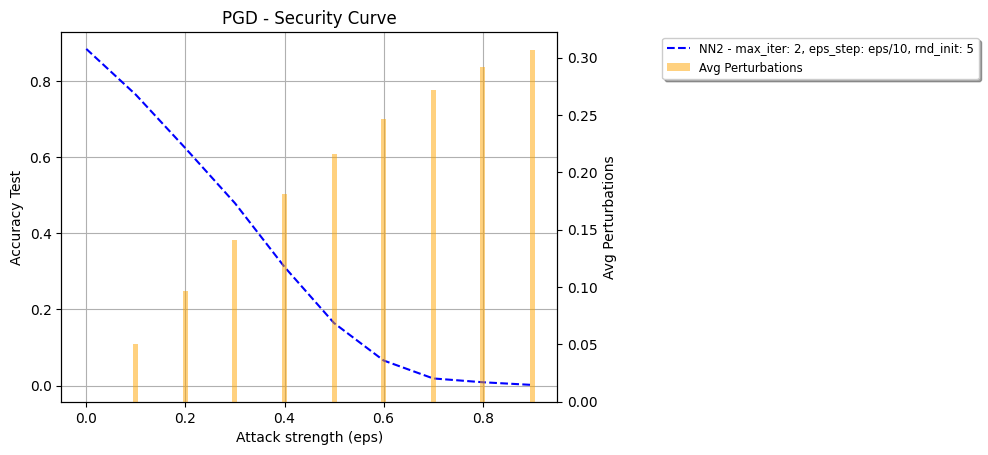

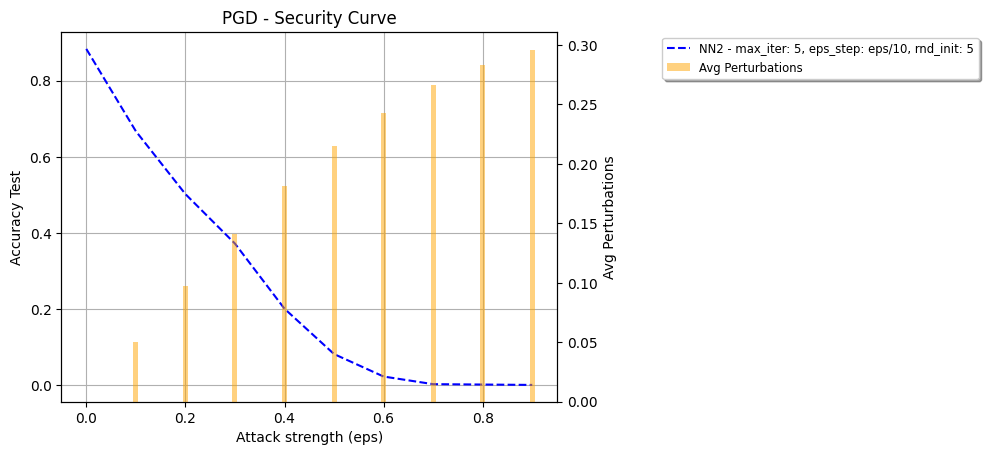

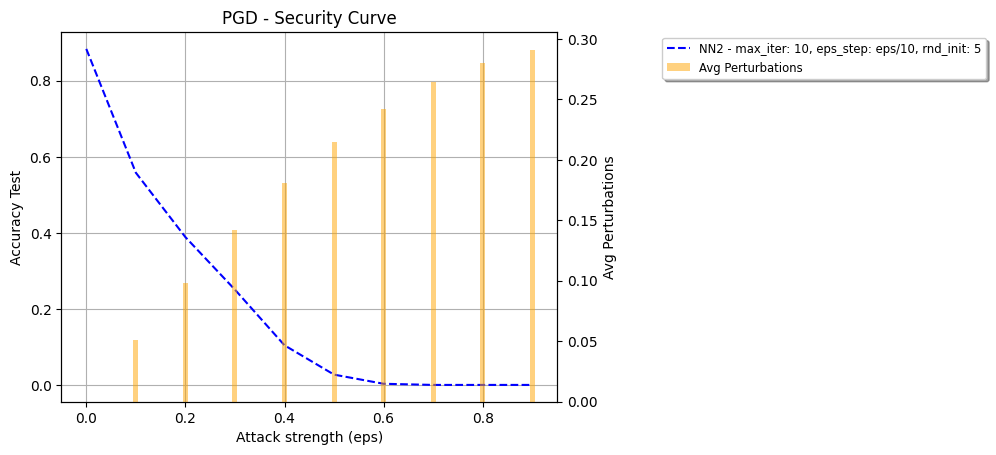

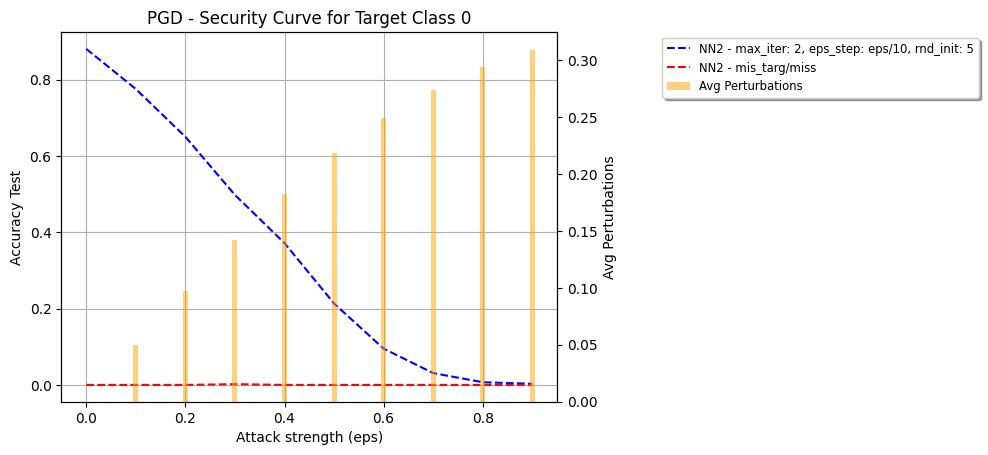

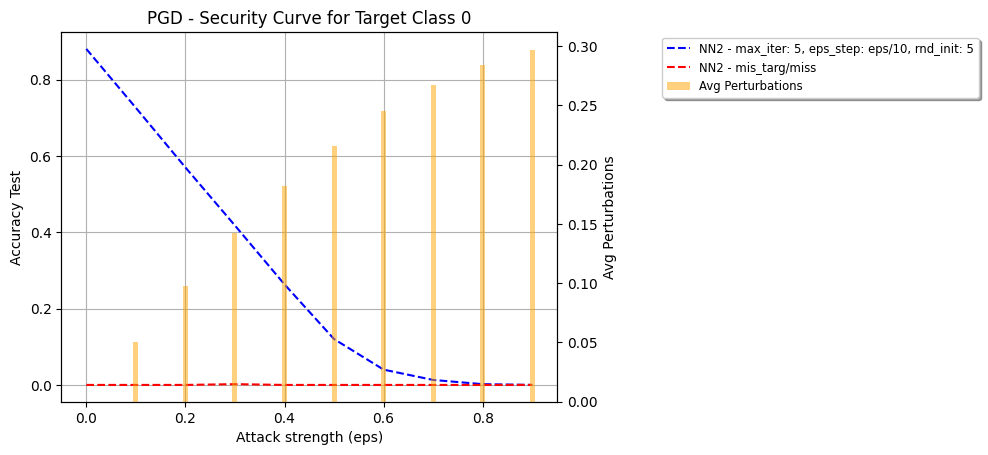

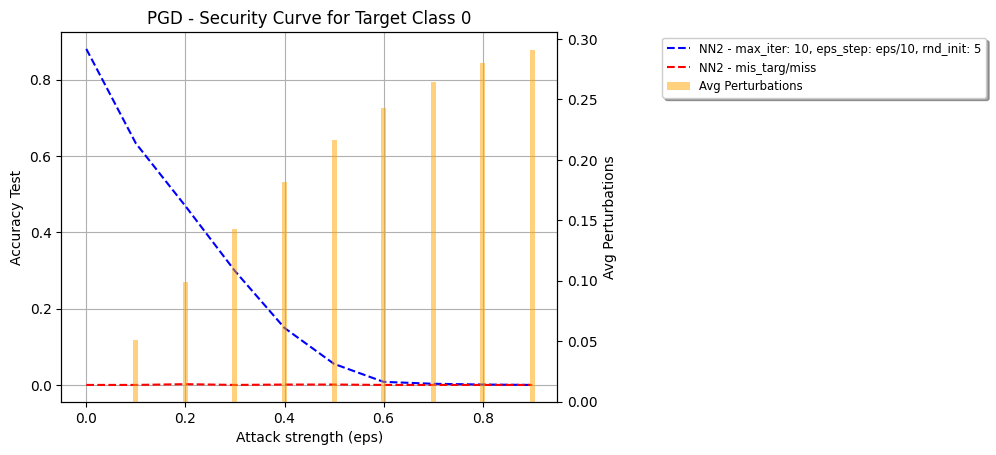

In [34]:
if IN_COLAB:
  results_csv = "/content/drive/Shareddrives/AI4CYBSEC/results/PGD/attack_results_NN2.csv"
else:
  results_csv = "results\PGD\\attack_results_NN2.csv"
network = "NN2"
read_csv_and_plot(results_csv, network)

### PGD NN1 with Defense

#### Load Robus Detector for pre-processing

In [17]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if IN_COLAB:
    directory = "/content/drive/Shareddrives/AI4CYBSEC/models"
else:
    directory = ".\models"
def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Definisci il modello mobilenet_v2
model = models.mobilenet_v2(pretrained=True)

# Sostituisci il classificatore dell'ultimo layer con un nuovo classificatore
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

model = model.to(device)


# carica i pesi del modello addestrato
model_name = "mobilenetv2_best_binary_classifier.pth"
#model_name = "best_mobilenetv2_df.pth"
defence = load_model(model, os.path.join(directory,model_name))

import torchsummary

# Stampa un riassunto del modello
torchsummary.summary(defence, (3, 160, 160))

c:\Program_for_ML\envs\AI4CyberSec\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Program_for_ML\envs\AI4CyberSec\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 80, 80]             864
       BatchNorm2d-2           [-1, 32, 80, 80]              64
             ReLU6-3           [-1, 32, 80, 80]               0
            Conv2d-4           [-1, 32, 80, 80]             288
       BatchNorm2d-5           [-1, 32, 80, 80]              64
             ReLU6-6           [-1, 32, 80, 80]               0
            Conv2d-7           [-1, 16, 80, 80]             512
       BatchNorm2d-8           [-1, 16, 80, 80]              32
  InvertedResidual-9           [-1, 16, 80, 80]               0
           Conv2d-10           [-1, 96, 80, 80]           1,536
      BatchNorm2d-11           [-1, 96, 80, 80]             192
            ReLU6-12           [-1, 96, 80, 80]               0
           Conv2d-13           [-1, 96, 40, 40]             864
      BatchNorm2d-14           [-1, 96,

#### Utility for inferece

In [18]:
def make_inference_defence(model, img_tensor, device):
    #img must be a tensor with shape (N, C, H, W)
    model.eval()
    img_tensor = img_tensor.to(device)
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()

def make_inference_NN1_with_defense(model,img_tensor, name_to_id, defense_model, device, isClean ):
    model.to(device)
    defense_model.to(device)
    prediction_defense = make_inference_defence(defense_model, img_tensor, device)
    if prediction_defense == 1:
        if not isClean:
            return 1, None
        return 0 ,None

    return make_inference(model, img_tensor, name_to_id, device)

def validate_with_defence(dataloader, model, name_to_id, device, defence_model, clean_data = True):
    """
    Validates a model on a dataset and returns the accuracy.

    Args:
        dataset: Dataloader to validate the model on.
        model: Model to validate.
        device: Device to perform inference on.

    Returns:
        accuracy: Accuracy of the model on the dataset.
    """
    model.to(device)
    model.eval()
    correct_predictions = 0
    total_samples = len(dataloader) * dataloader.batch_size
    num_skipped_samples = 0
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in tqdm(dataloader, desc="Validating model"):
            predicted_classes, _= make_inference_NN1_with_defense(model, images, name_to_id, defence_model, device, clean_data)
            if predicted_classes == 1:# significa che ho predetto come adv un campione  adv
                num_skipped_samples += 1
                correct_predictions += 1
                continue
            elif predicted_classes == 0:# significa che ho predetto come adv un campione  clean
                num_skipped_samples += 1
                continue
            # DATO CHE C'è il continue è come se avessi un else:
            correct_predictions += sum(pred == label for pred, label in zip(predicted_classes, labels))


    # Compute accuracy
    accuracy = correct_predictions / total_samples
    return accuracy, num_skipped_samples

#### Validation on clean data with defense

In [19]:
# Create transform for image resizing and normalization

data_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor()
])

if IN_COLAB:
  test_set_path = "/content/drive/Shareddrives/AI4CYBSEC/face_dataset/test_set_MTCNN"
else:
  test_set_path = "./face_dataset/test_set_MTCNN"
# Define dataset
dataset = VGGFace2Dataset(root_dir=test_set_path, transform=data_transform)

# Check the length of the dataset
print("Dataset length:", len(dataset))

# Create DataLoader
batch_size = 1
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
acc = validate(dataloader, resnet, name_to_id, device)
print("\n Accuracy without defense "+str(acc))

acc_with_defence, num_skipped_samples = validate_with_defence(dataloader, resnet, name_to_id, device, defence, clean_data = True)
print("\n Accuracy with defense "+str(acc_with_defence))


Dataset length: 998


Validating model: 100%|██████████| 998/998 [00:28<00:00, 34.58it/s]



 Accuracy without defense 0.8346693386773547


Validating model: 100%|██████████| 998/998 [00:39<00:00, 25.38it/s]


 Accuracy with defense 0.8306613226452906


### PGD attack with defence -- NN1

In [38]:
PERFORM_ATTACK_NN1_with_defense= False

#### Load list of images and labels

In [39]:
images_list = []
labels_list = []
images_adv_list = []
for image, label in dataloader:
    # Effettua le predizioni del modello
    # image numpy on device
    image_numpy = image.numpy()
    images_list.append(image_numpy)
    labels_list.append(label)

#### Set variable Perform Attack

In [40]:

if IN_COLAB:
  results_csv = "/content/drive/Shareddrives/AI4CYBSEC/results/PGD/attack_results_NN1_with_defense.csv"
else:
  results_csv = "results\PGD\\attack_results_NN1_with_defense.csv"
network = "NN1_with_defense"

#### Perform attack Error Generic White Box

In [41]:
if PERFORM_ATTACK_NN1_with_defense:
  from tqdm import tqdm
  from art.attacks.evasion import ProjectedGradientDescent
  import time

  attack_name = "PGD"
  targeted = False

  epsilon = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
  # Set the epsilon step size for the attack 1/10 of epsilon
  max_iters = [2, 5, 10]
  #max_iters = [ 5, 10, 20]
  num_random_init = 5 # for reproducibility
  target_class = None

  for max_iter in max_iters:
    accuracy = [acc_with_defence]
    avg_perturbations = [0]
    for eps in epsilon:
      attack = ProjectedGradientDescent(estimator=classifier, eps=eps, eps_step=eps/10,
                                        max_iter=max_iter, num_random_init=num_random_init, targeted=targeted,
                                        verbose=False)
      num_skipped_samples = 0
      correct = 0
      images_adv_list = []
      for img, label in tqdm(zip(images_list, labels_list), total=len(images_list),
                              desc="Attacking model with eps={} eps_step={} max_iter={} num_random_init={}".format(eps, eps/10, max_iter, num_random_init)):
        x_test_adv = attack.generate(img)
        images_adv_list.append(x_test_adv)
        x_test_adv = torch.tensor(x_test_adv)


        x_test_adv_pred, _= make_inference_NN1_with_defense(resnet, x_test_adv, name_to_id, defence, device, isClean=False)
        if x_test_adv_pred == 1:# significa che ho predetto come adv un campione  adv
            num_skipped_samples += 1
            correct += 1
            continue
        elif x_test_adv_pred == 0:# significa che ho predetto come adv un campione  clean
            num_skipped_samples += 1
            continue
        if x_test_adv_pred[0] == label[0]:
          correct +=1
      accuracy.append(correct/len(images_list))
      avg_perturbations.append(compute_perturbation(images_list, images_adv_list))
      print("accuracy: ", correct/len(images_list))
      print("Number of skipped samples: ", num_skipped_samples)
    epsilon_ext= [0] + epsilon
    constant_values ={"max_iter":max_iter, "eps_step": "eps/10", "rnd_init":num_random_init}
    strength_name = "eps"

    sec_curve(epsilon_ext, accuracy, constant_values, strength_name, target_class, attack_name, avg_perturbations, None, network)
    # save results on csv
    save_to_csv(attack_name, targeted, target_class, strength_name, epsilon_ext, accuracy, constant_values, avg_perturbations, results_csv)


#### Perform attack Error Specific White Box

In [42]:
if PERFORM_ATTACK_NN1_with_defense:
  from tqdm import tqdm
  from art.attacks.evasion import ProjectedGradientDescent
  import time

  attack_name = "PGD"
  targeted = True

  epsilon = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
  # Set the epsilon step size for the attack 1/10 of epsilon
  max_iters = [2, 5, 10]
  #max_iters = [ 20]
  num_random_init = 5 # for reproducibilityprint("\nCorrect Prediction: ", correct,"/",len(images_list), " Error equal target: ", error_equl_target,"/",len(images_list)-correct)

  target_class = 0 ## n000002
  """
  Target_label (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape
            (nb_samples,). Only provide this parameter if you'd like to use true labels when crafting
            adversarial samples. Otherwise, model predictions are used as labels to avoid the "label leaking" effect

  """
  #ndarray of shape (nb_samples, nb_classes) one-hot-encoded labels
  one_hot_bob_targeted_label = np.zeros((1, 8631))
  one_hot_bob_targeted_label[:, target_class] = 1

  for max_iter in max_iters:
    accuracy = [acc_with_defence]
    avg_perturbations = [0]
    mis_equal_target_ratio = [0] # this is the case in wich I don't perform the attack (assumption)
    for eps in epsilon:
      attack = ProjectedGradientDescent(estimator=classifier, eps=eps, eps_step=eps/10,
                                        max_iter=max_iter, num_random_init=num_random_init, targeted=targeted,
                                        verbose=False)
      correct = 0
      num_skipped_samples = 0
      error_equl_target=0
      images_adv_list = []
      for img, label in tqdm(zip(images_list, labels_list), total=len(images_list),
                              desc="Attacking model with eps={} eps_step={} max_iter={} num_random_init={}".format(eps, eps/10, max_iter, num_random_init)):
        x_test_adv = attack.generate(img, one_hot_bob_targeted_label)
        images_adv_list.append(x_test_adv)
        x_test_adv = torch.tensor(x_test_adv)

        x_test_adv_pred, x_test_adv_pred_model= make_inference_NN1_with_defense(resnet, x_test_adv, name_to_id, defence, device, isClean=False)
        if x_test_adv_pred == 1:# significa che ho predetto come adv un campione  adv
            num_skipped_samples += 1
            correct += 1
            continue
        elif x_test_adv_pred == 0:# significa che ho predetto come adv un campione  clean
            num_skipped_samples += 1
            continue

        if x_test_adv_pred[0] == label[0]:
          correct +=1
        elif x_test_adv_pred_model[0] == target_class:
          error_equl_target+=1
      if correct == len(images_list):
        mis_equal_target_ratio.append(0)
      else:
        mis_equal_target_ratio.append(round(error_equl_target/(len(images_list)-correct),3))
      accuracy.append(correct/len(images_list))
      avg_perturbations.append(compute_perturbation(images_list, images_adv_list))
      print("Correct Prediction: ", correct,"/",len(images_list), " Error equal target: ", error_equl_target,"/",len(images_list)-correct)
      print("Accuracy: ", correct/len(images_list))
      print("Number of skipped samples: ", num_skipped_samples)
    epsilon_ext= [0] + epsilon
    constant_values ={"max_iter":max_iter,"eps_step": "eps/10", "rnd_init":num_random_init, }
    strength_name = "eps"
    sec_curve(epsilon_ext, accuracy, constant_values, strength_name, target_class, attack_name, avg_perturbations, mis_equal_target_ratio, network)
    # save results on csv
    save_to_csv(attack_name, targeted, target_class, strength_name, epsilon_ext, accuracy, constant_values, avg_perturbations, results_csv, mis_equal_target_ratio)


#### Plot csv attack with defense NN1

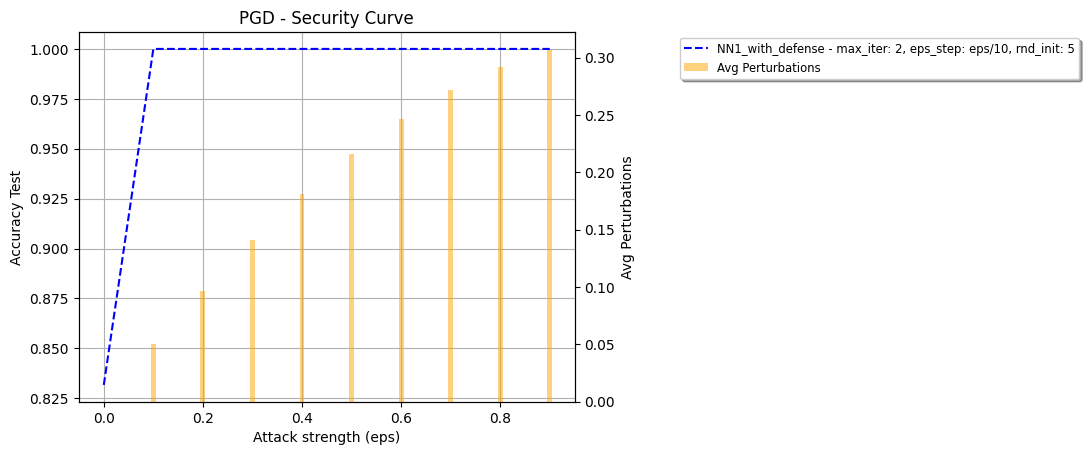

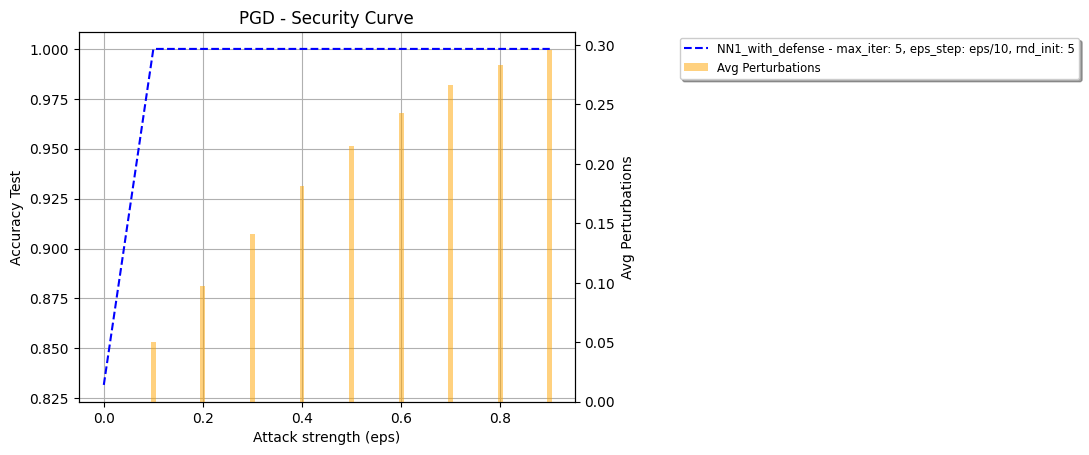

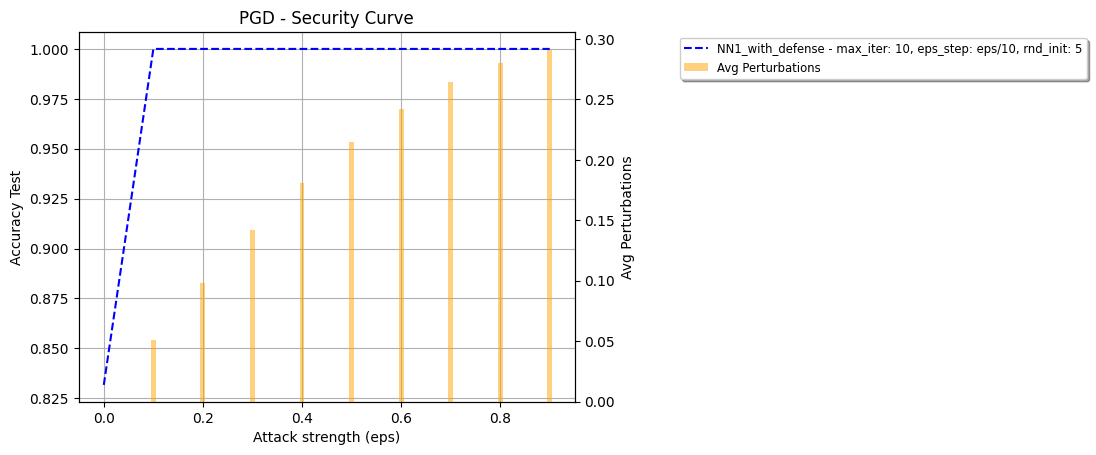

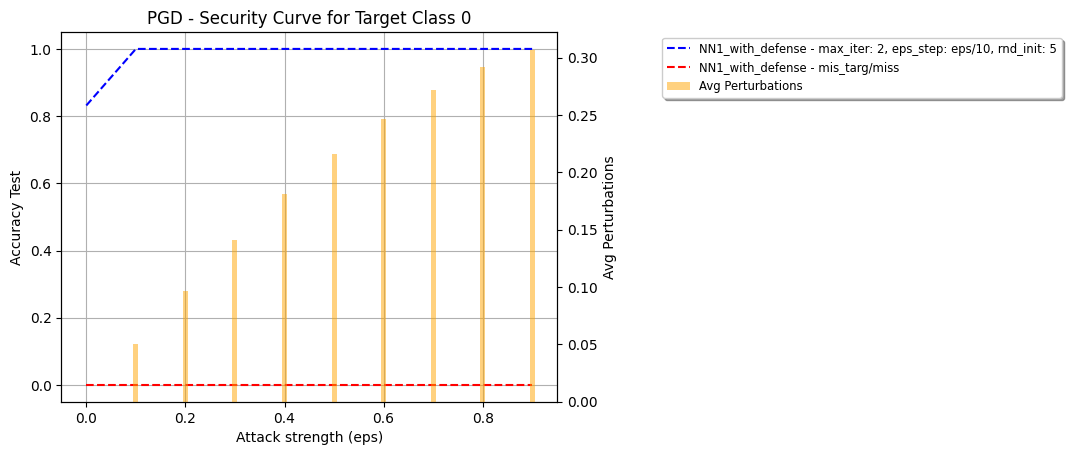

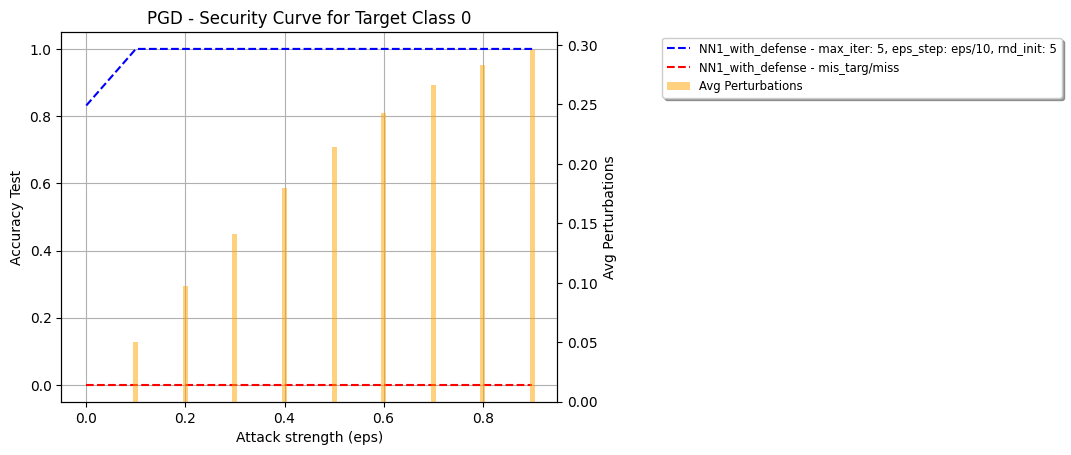

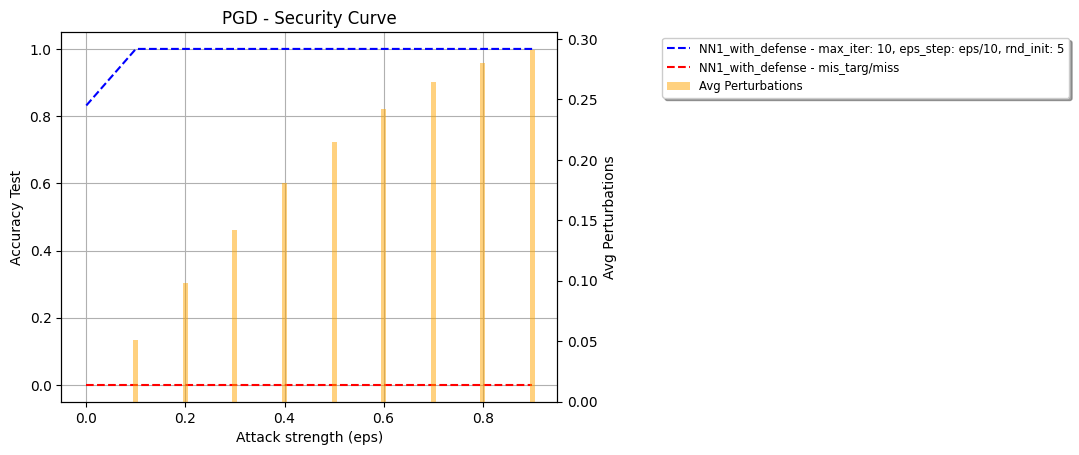

In [43]:

if IN_COLAB:
  results_csv = "/content/drive/Shareddrives/AI4CYBSEC/results/PGD/attack_results_NN1_with_defense.csv"
else:
  results_csv = "results\PGD\\attack_results_NN1_with_defense.csv"
network = "NN1_with_defense"
read_csv_and_plot(results_csv, network)
